In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import date
import quandl

plt.style.use('fivethirtyeight')
%matplotlib inline

- Importing and Discovering the data

In [2]:
# Getting the stocks data
data = pd.read_excel(r'C:\Users\jguer_gompqqi\OneDrive\Documents\Data Science\Machine Learning\Datasets & Projects\Databases\Listings.xlsx', 
                     index_col = 0, sheet_name='nasdaq')
data.head()

,Company Name,Sector,Industry
Stock Symbol,,,
AAPL,Apple Inc.,Technology,Computer Manufacturing
GOOGL,Alphabet Inc.,Technology,"Computer Software: Programming, Data Processing"
GOOG,Alphabet Inc.,Technology,"Computer Software: Programming, Data Processing"
MSFT,Microsoft Corporation,Technology,Computer Software: Prepackaged Software
AMZN,"Amazon.com, Inc.",Consumer Services,Catalog/Specialty Distribution


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3163 entries, AAPL to ZIONZ
Data columns (total 3 columns):
Company Name    3163 non-null object
Sector          2763 non-null object
Industry        2763 non-null object
dtypes: object(3)
memory usage: 98.8+ KB


,Company Name,Sector,Industry
count,3163,2763,2763
unique,2885,12,127
top,Liberty Media Corporation,Health Care,Major Pharmaceuticals
freq,6,645,349


As we can see the most frequent sector of the NASDAQ is the Health Care, with nearly 1/4 of the companies.

For the "Sector" and "Industry" columns, we'll use the 'category' dtype instead of 'objects', to save memory.
The missing values mostly correspond to ETFs (or trackers : funds that replicate a large market index), not company stocks : we can drop them.

There are also duplicates in the company names that we want to get rid of. 

- Data cleaning

In [4]:
# Change the columns dtype
data = data.astype({'Sector' : 'category', 'Industry' : 'category'})

# Drop missing values and duplicates
data = data.dropna()
data = data.drop_duplicates()

data.info()    # we just saved 46KB of memory

<class 'pandas.core.frame.DataFrame'>
Index: 2507 entries, AAPL to VVPR
Data columns (total 3 columns):
Company Name    2507 non-null object
Sector          2507 non-null category
Industry        2507 non-null category
dtypes: category(2), object(1)
memory usage: 52.9+ KB


Now we have a clean dataset with no duplicates or missing values. We can start the financial analysis.

In the Sharpe Ratio formula, we need the stock's expected rate of return, and its volatility (the standard deviation of the market price is considered as a measure of risk).

In [5]:
# Collecting the data

# List of all the stocks tickers
stocks_ticker = data.index.tolist()

# Initialize the parameters
start = date(2014, 1, 1)
end = date(2019, 1, 1)

stocks = pd.DataFrame()
error_list =[]
x = 0

# Data of the NASDAQ 100
while x <= 100 :
    try :
        tickers = stocks_ticker[x]
        new_selection = DataReader(tickers, 'iex', start, end)['close']
        new_selection.rename(tickers, inplace=True)
        stocks = pd.concat([stocks, new_selection], axis=1, sort=False)
        x += 1

    # some values in the list are not up to date    
    except KeyError :  
        continue 

In [6]:
# Create a Datetime index
stocks['Date'] = pd.to_datetime(stocks.index)
stocks = stocks.set_index('Date')

stocks.iloc[:,:5].head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2014-04-22,69.8290,545.50,35.5751,329.32,63.0301
2014-04-23,68.9164,537.51,35.3082,324.58,61.3600
2014-04-24,74.5663,534.44,35.4595,337.15,60.8700
2014-04-25,75.1140,523.10,35.5040,303.83,57.7100
2014-04-28,78.0230,522.98,36.3580,296.58,56.1400


In [7]:
# Saving this dataframe
stocks.to_pickle('NASDAC.pkl')
stocks = pd.read_pickle('NASDAC.pkl')

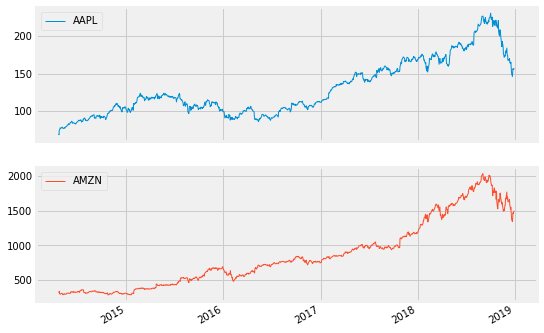

In [8]:
# Charts of the stock price evolution
stocks.loc[:, ['AAPL', 'AMZN']].plot(linewidth=1, subplots=True, figsize=(8, 6))
plt.xlabel('')

plt.show()

- Computing the key metrics

In [9]:
# Average daily return
avg_daily_return = np.mean(stocks.pct_change() + 1)

# Average annual return (in %)
avg_annual_return = (avg_daily_return ** 252 - 1) * 100 # 252 trading days

# Convert to a DataFrame
avg_annual_return = avg_annual_return.to_frame('Annual Return')

# 5 best average return
avg_annual_return.nlargest(5, 'Annual Return')

,Annual Return
NVDA,61.456095
NFLX,50.483463
AMZN,41.677483
AVGO,41.540013
NTES,36.400405


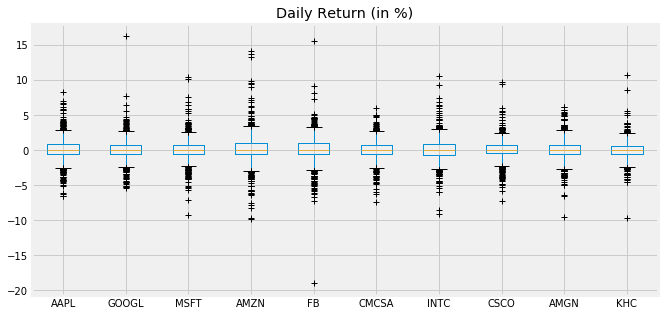

In [32]:
# Boxplot of the daily stocks return

(stocks.pct_change()*100).iloc[:, :10].plot(kind='box',sym='k+', figsize=(10, 5))

plt.title('Daily Return (in %)')

plt.show()

As we can see with this 10-stocks selection, the return can vary greatly from one day to another. Facebook's (FB) volatility is quite extreme : during this 4-years period, investors would have known a +16% but also a -19% price variation of their asset, during a single day !

Also the Google (GOOGL) case is quite interesting : even though their shareholders wouldn't have benefited from as many high daily-returns as Amazon (AMZN), their investment might actually be 'safer'.
Indeed, its market capitalisation vary from -5% to +17%, meaning that the stock's downside deviation (volatility of the negative returns, also called negative deviation) is much smaller that Amazon, which suffer from many days in the [-10%, -5%] range.                
Said differently, investing in Google might cause less bad-surprises than in Facebook or Amazon.

In [11]:
# Daily volatility / risk of each asset
daily_volatility = np.std(stocks.pct_change() * 100)

# Annualized volatility
annual_volatility = daily_volatility * np.sqrt(252)
annual_volatility = annual_volatility.to_frame('Annual Volatility')

# 7 least volatile securities
annual_volatility.nsmallest(7, 'Annual Volatility')

,Annual Volatility
HBANO,10.507138
PAYX,16.573055
FISV,16.766471
COST,17.945711
VRSK,17.958693
WLTW,18.416562
CME,18.485393


In [12]:
# Sharpe Ratio (2.5% risk-free rate of return)
stocks_SharpeRatio = pd.DataFrame()
stocks_SharpeRatio['Sharpe Ratio'] = (avg_annual_return['Annual Return'] - 2.5) / annual_volatility['Annual Volatility']

# Put it all together
df_stocks = pd.concat([data, avg_annual_return, annual_volatility, stocks_SharpeRatio], axis=1, sort=False)
df_stocks.head()

,Company Name,Sector,Industry,Annual Return,Annual Volatility,Sharpe Ratio
AAPL,Apple Inc.,Technology,Computer Manufacturing,20.907775,23.407930,0.786391
GOOGL,Alphabet Inc.,Technology,"Computer Software: Programming, Data Processing",16.803553,22.472706,0.636486
MSFT,Microsoft Corporation,Technology,Computer Software: Prepackaged Software,26.455135,22.521770,1.063644
AMZN,"Amazon.com, Inc.",Consumer Services,Catalog/Specialty Distribution,41.677483,29.860012,1.312038
FB,"Facebook, Inc.",Technology,Technology,20.309114,27.477857,0.648126


In [13]:
# Top 5 Sharpe Ratio of our selection
stocks_SharpeRatio.nlargest(5, 'Sharpe Ratio')

,Sharpe Ratio
NVDA,1.481580
CME,1.386806
AMZN,1.312038
AVGO,1.218833
FISV,1.198307


Here is the list of the 5 highest Sharpe Ratio among the corporations we can find in the NASDAQ100.
We usually consider that a Sharpe Ratio > 1 is pretty satisfying because it means the excess return (return of the stock - risk-free return) is superior to the volatility of the investment.

Nvidia (NVDA) achieves to obtain the highest score, despite a very high volatility rate (nearly 40% per annum). However, the Sharpe Ratio rewards both high return and moderate risk, and Nvidia is by far the leader of the index when it comes to market performance, with a whopping 61.7% increase, in average, during 4 years !

In [14]:
# CME key metrics
df_stocks.loc[['NVDA'], :]

,Company Name,Sector,Industry,Annual Return,Annual Volatility,Sharpe Ratio
NVDA,NVIDIA Corporation,Technology,Semiconductors,61.456095,39.792718,1.48158


- Sectorial analysis of the Sharpe Ratio

In [15]:
# Display the return, volatility and Sharpe Ratio for each sector
group_sectors = df_stocks.groupby('Sector')['Annual Return', 'Annual Volatility', 'Sharpe Ratio'].mean().dropna()

# Count the number of values in each category
group_sectors['Count'] = df_stocks.groupby('Sector')['Sharpe Ratio'].count()

# Add a feature 'cyclical', or 'defensive'
cyclical = ['Finance', 'Technology', 'Consumer Durables', 'Miscellaneous', 'Capital Goods']
defensive = ['Health Care', 'Public Utilities', 'Consumer Non-Durables', 'Transportation', 'Consumer Services']
sectors = list(group_sectors.index)
eco_cycle = pd.DataFrame()

for sector in sectors :
    if sector in cyclical :
        #group_sectors.loc[sector, 'Economic cycle'] = 'Cyclical'
        eco_cycle.loc[sector, 'Cycle'] = 'Cyclical'
    else :
        #group_sectors.loc[sector, 'Economic cycle'] = 'Defensive'
        eco_cycle.loc[sector, 'Cycle'] = 'Defensive'
    
# Insert this series in our dataframe
group_sectors.insert(0, column='Cyclicality', value=eco_cycle)
    
# Order the rows 
group_sectors.sort_values(by='Sharpe Ratio', ascending=False)

,Cyclicality,Annual Return,Annual Volatility,Sharpe Ratio,Count
Sector,,,,,
Consumer Durables,Cyclical,24.088192,21.222787,1.017218,1
Technology,Cyclical,18.109433,27.242033,0.595098,36
Consumer Services,Defensive,15.571552,26.317748,0.526320,22
Finance,Cyclical,13.351145,20.691217,0.517664,8
Miscellaneous,Cyclical,17.382836,31.967067,0.462042,5
Transportation,Defensive,14.226514,31.053585,0.427729,2
Capital Goods,Cyclical,15.752462,32.346500,0.380783,4
Public Utilities,Defensive,10.274269,28.243807,0.307524,2
Health Care,Defensive,9.906418,30.213863,0.252434,17


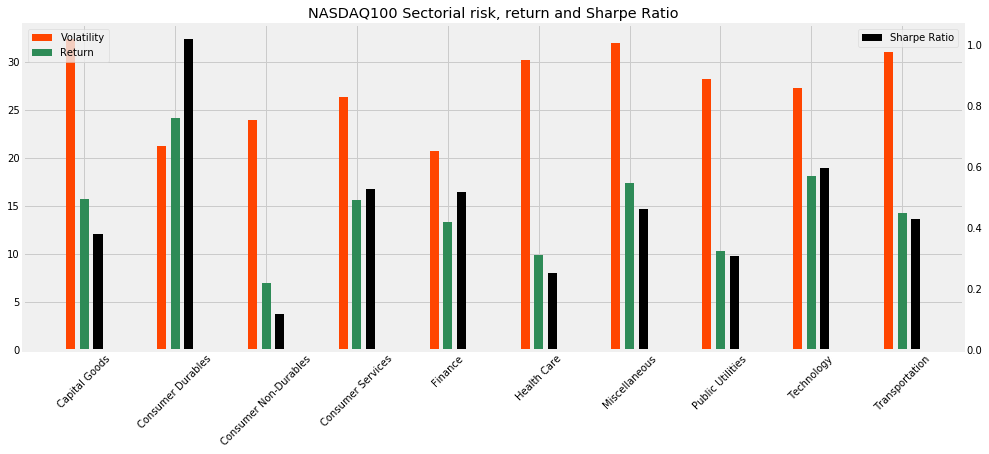

In [16]:
# 3 columns used for the bar plot
x = group_sectors['Annual Volatility']
y = group_sectors['Sharpe Ratio']
z = group_sectors['Annual Return']

# List containing the sectors
sector_list = list(group_sectors.index)
indices = np.arange(10)
width = 0.1

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Bar of the volatility and Sharpe ratio on the left axis
ax.bar(indices - width - 0.05, x, width, color='orangered', label='Volatility')
ax1 = ax.bar(indices, z, width, color='seagreen', label='Return')

# Return bar plot on the right axis
ax2 = ax.twinx()
ax2.bar(indices + width + 0.05, y, width, color='black', label='Sharpe Ratio')
ax2.grid(False)

# Setting the title, legend, x-label
ax.set_title('NASDAQ100 Sectorial risk, return and Sharpe Ratio')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(indices, labels = sector_list, rotation=45)
ax.tick_params(axis='x', rotation=45)

plt.show()

We must be careful here, as the companies repartition among the sectors is not uniform : we can't really give a general estimation for the 'Consumer Durables', or the 'Transportation' industry's Sharpe Ratio for example, as they don't contain enough data.
The leading position of the Consumer Durables might be due to one outstanding stock, and may not reflect the general trend.

In [17]:
cycle_group = group_sectors.groupby('Cyclicality')['Annual Return', 'Annual Volatility', 'Sharpe Ratio'].mean()
cycle_group

,Annual Return,Annual Volatility,Sharpe Ratio
Cyclicality,,,
Cyclical,17.736813,26.693921,0.594561
Defensive,11.379546,27.951214,0.326384


As we would expect, cyclical industries tend to offer a much higher rate of return (17.7% vs 11.4%), which make sense if we believe that those kind of industries tend to amplify the market movement. During the years 2015-2019 the economy was in a bull market, hence the good performances of these sectors.
This is the reason why they score higher in the return to volatility ratio.

However, it's quite surprising to note that the annual volatility of the defensive values is slightly higher than the cyclical one. It could be due to the Health Care industry, a very large contributor in the Defensive field, which pushes up the average with its 30.2% volatility.

In [19]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Circle, CategoricalColorMapper, HoverTool
import bokeh.io

output_notebook()

Loading BokehJS ...

In [33]:
sector_list = list(group_sectors.index)

# Interactive graph of the risk / return of each stock
plot = figure(plot_width=990, plot_height=400, x_range=(10, 55),
              tools=['hover,box_select, lasso_select'])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

# Scatter plot with color differing according to the sector
mapper = CategoricalColorMapper(factors=sector_list, palette=colors)#Magma256

plot.circle('Annual Volatility', 'Annual Return', size=7, source=df_stocks, 
            name='circle', color={'field':'Sector', 'transform':mapper}, legend='Sector')

# Interactive tool selecting a stock
hover = HoverTool(names=['circle'], tooltips=[('Company Name', '@{Company Name}'), ('Sector', '@Sector'),
                                              ('Sharpe Ratio', '@{Sharpe Ratio}{0.2f}')])

plot.add_tools(hover)

# Add titles, labels
plot.xaxis.axis_label = 'volatility (%)'
plot.yaxis.axis_label = 'return (%)'

plot.title.text = 'NASDAQ100 Risk / Return interactive map'
plot.title.align = 'center'

bokeh.io.show(plot)